Processing low_utilization...

Results for low_utilization:
Best performing model: VI_mdp

PI_mdp: -14197.87(124.06)
PI_smdp: -14292.94(130.14)
VI_mdp: -14130.03(123.41)
PPO_mdp_AUC_case_limit: -481790.85(15919.78)
PPO_smdp_AUC_case_limit: -14719.11(152.58)
PPO_smdp_case_cycle_time_case_limit: -851355.86(22625.24)
PPO_smdp_inverse_case_cycle_time_case_limit: -14485.69(130.01)
Heuristic_spt: -14702.25(135.91)
Heuristic_fifo: -14843.79(157.80)
Heuristic_random: -16642.10(202.51)
PI_mdp vs VI_mdp:
t-statistic: 0.7586
p-value: 0.4484
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 1.7774
p-value: 0.0760
Significant difference: False

14130.034680581435


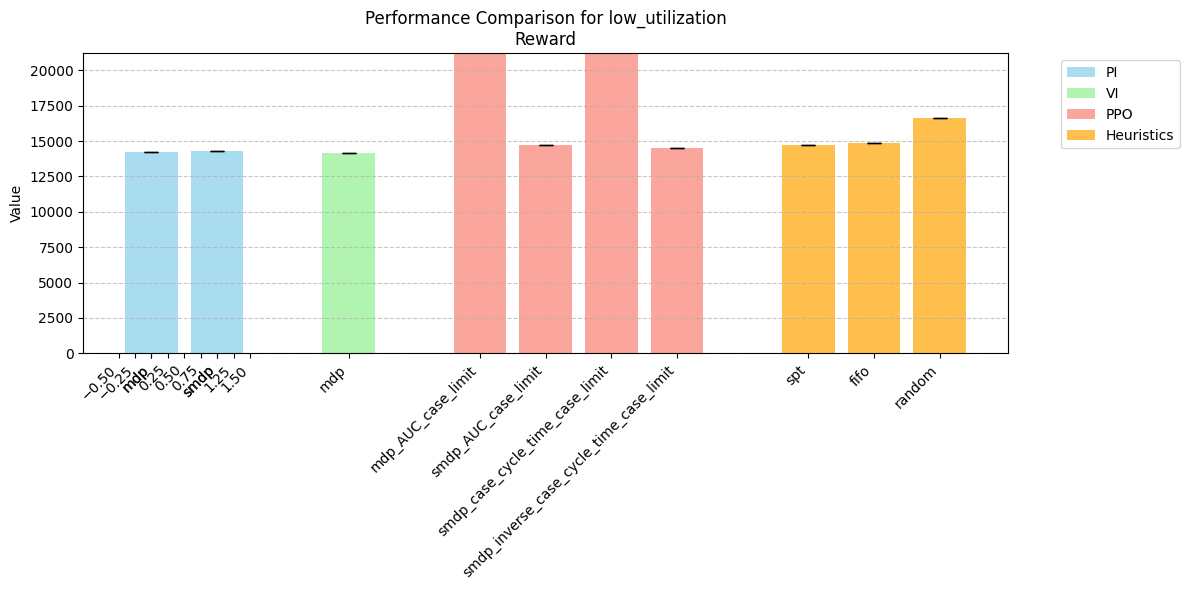

Processing high_utilization...

Results for high_utilization:
Best performing model: VI_mdp

PI_mdp: -46654.79(1406.07)
PI_smdp: -45347.34(1507.74)
VI_mdp: -44954.00(1382.13)
PPO_mdp_AUC_case_limit: -2046226.41(22781.66)
PPO_smdp_AUC_case_limit: -1753700.86(22479.49)
PPO_smdp_case_cycle_time_case_limit: -2244338.45(26162.63)
PPO_smdp_inverse_case_cycle_time_case_limit: -49347.48(1707.74)
Heuristic_spt: -49046.54(1580.00)
Heuristic_fifo: -67086.38(3369.26)
Heuristic_random: -90141.94(5296.96)
PI_mdp vs VI_mdp:
t-statistic: 1.6879
p-value: 0.0919
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 0.3763
p-value: 0.7068
Significant difference: False

44953.99811181169


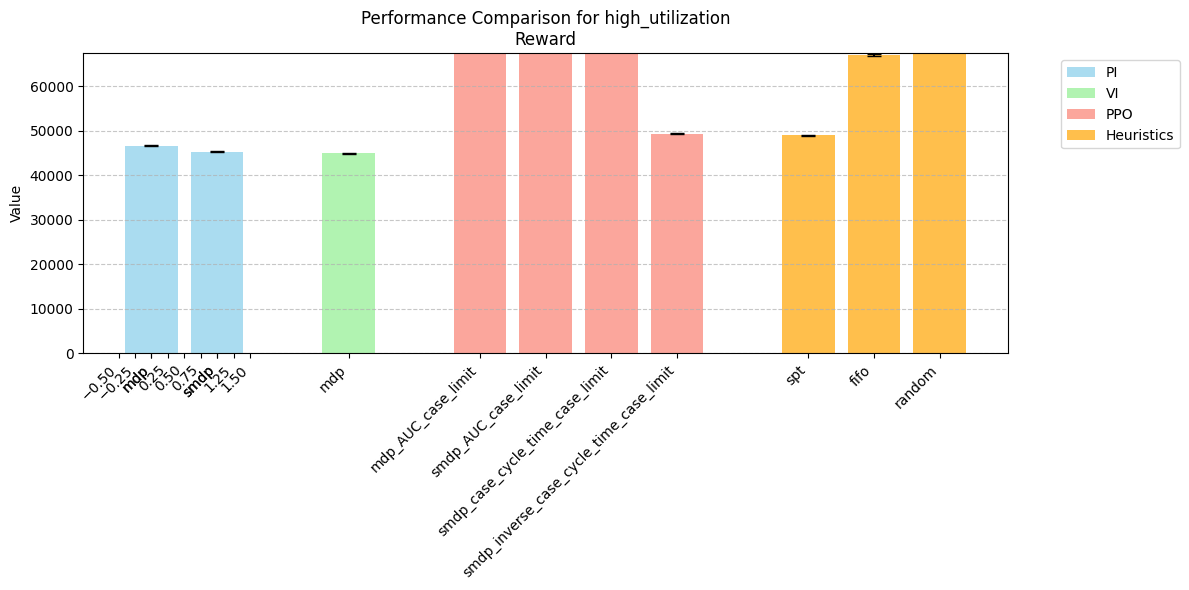

Processing slow_server...

Results for slow_server:
Best performing model: VI_mdp

PI_mdp: -30030.30(507.04)
PI_smdp: -29653.49(614.90)
VI_mdp: -29269.83(566.93)
PPO_mdp_AUC_case_limit: -2026465.15(22711.67)
PPO_smdp_AUC_case_limit: -1810176.36(24856.74)
PPO_smdp_case_cycle_time_case_limit: -2147286.25(24400.32)
PPO_smdp_inverse_case_cycle_time_case_limit: -29764.42(535.19)
Heuristic_spt: -73507.53(3374.60)
Heuristic_fifo: -46413.81(1690.79)
Heuristic_random: -57047.82(2395.16)
PI_mdp vs VI_mdp:
t-statistic: 1.9564
p-value: 0.0509
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 0.8976
p-value: 0.3698
Significant difference: False

PPO_smdp_inverse_case_cycle_time_case_limit vs VI_mdp:
t-statistic: 1.2413
p-value: 0.2150
Significant difference: False

29269.83126320516


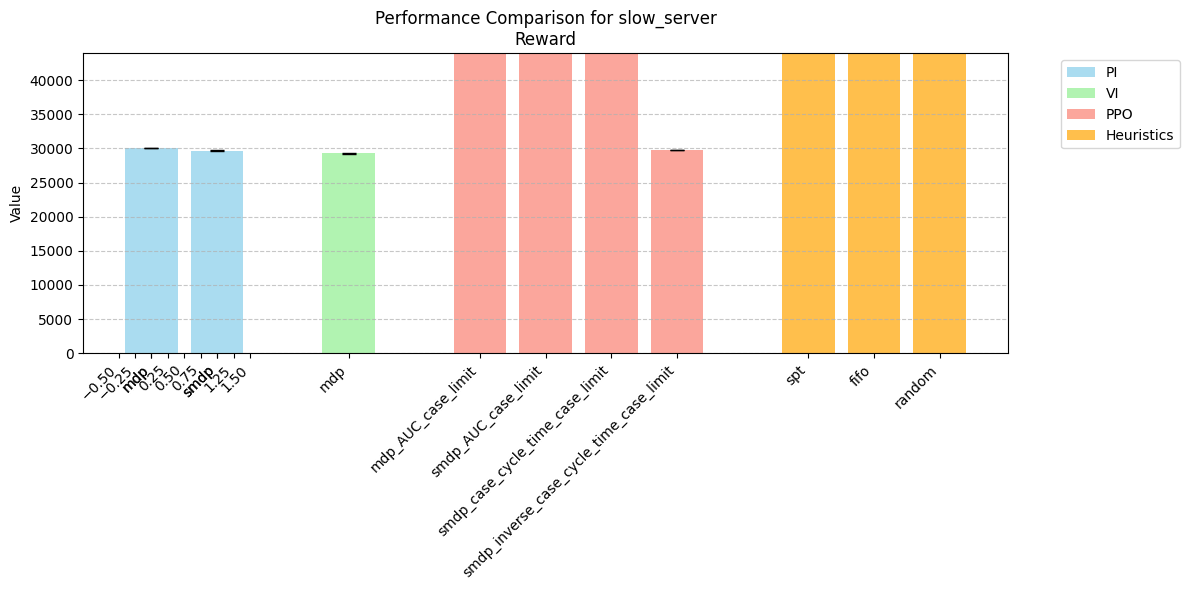

Processing n_system...

Results for n_system:
Best performing model: VI_mdp

PI_mdp: -14533.55(147.61)
PI_smdp: -14712.64(155.72)
VI_mdp: -14497.90(150.94)
PPO_mdp_AUC_case_limit: -481375.23(13172.96)
PPO_smdp_AUC_case_limit: -14708.36(151.66)
PPO_smdp_case_cycle_time_case_limit: -713642.89(14933.52)
PPO_smdp_inverse_case_cycle_time_case_limit: -5008260.84(19219.81)
Heuristic_spt: -17959.92(265.01)
Heuristic_fifo: -14687.62(149.35)
Heuristic_random: -16195.47(229.27)
PI_mdp vs VI_mdp:
t-statistic: 0.3304
p-value: 0.7412
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 1.9375
p-value: 0.0531
Significant difference: False

PPO_smdp_AUC_case_limit vs VI_mdp:
t-statistic: 1.9246
p-value: 0.0547
Significant difference: False

Heuristic_fifo vs VI_mdp:
t-statistic: 1.7483
p-value: 0.0809
Significant difference: False

14497.89633034573


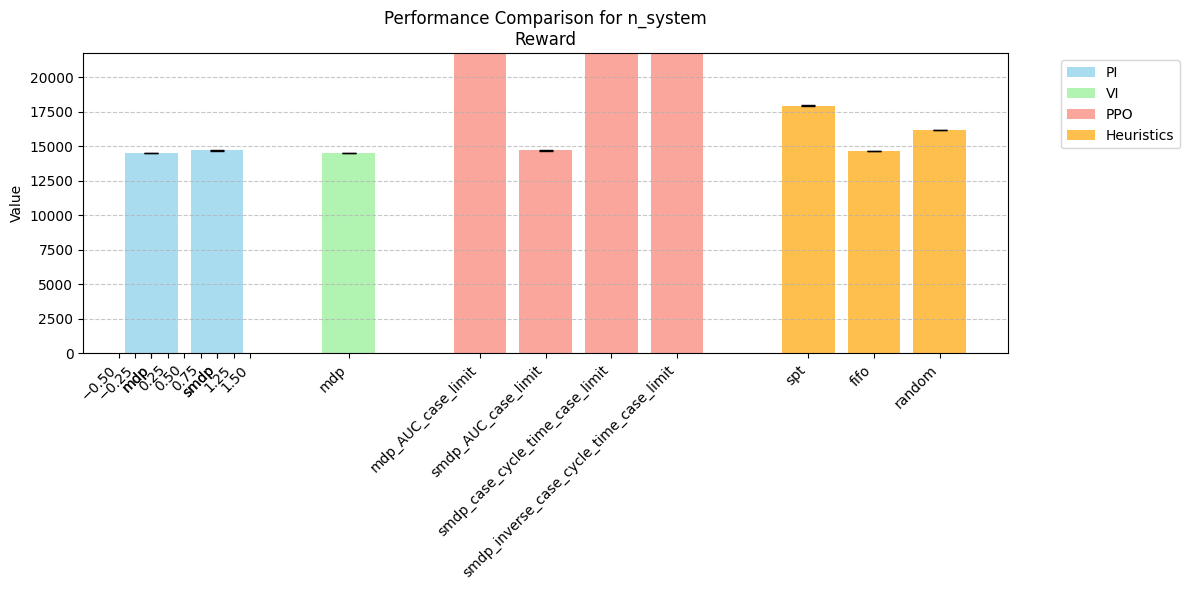

Processing down_stream...

Results for down_stream:
Best performing model: VI_mdp

PI_mdp: -25061.13(487.30)
PI_smdp: -25384.88(484.74)
VI_mdp: -25115.04(502.65)
PPO_mdp_AUC_case_limit: -1219216.45(20093.70)
PPO_smdp_AUC_case_limit: -633868.11(14994.42)
PPO_smdp_case_cycle_time_case_limit: -1439287.57(23216.19)
PPO_smdp_inverse_case_cycle_time_case_limit: -25027.41(540.17)
Heuristic_spt: -36865.19(876.11)
Heuristic_fifo: -24987.96(463.40)
Heuristic_random: -28866.79(620.48)
PI_mdp vs VI_mdp:
t-statistic: -0.1507
p-value: 0.8803
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 0.7561
p-value: 0.4499
Significant difference: False

PPO_smdp_inverse_case_cycle_time_case_limit vs VI_mdp:
t-statistic: -0.2324
p-value: 0.8163
Significant difference: False

Heuristic_fifo vs VI_mdp:
t-statistic: -0.3637
p-value: 0.7162
Significant difference: False

24987.9619294353


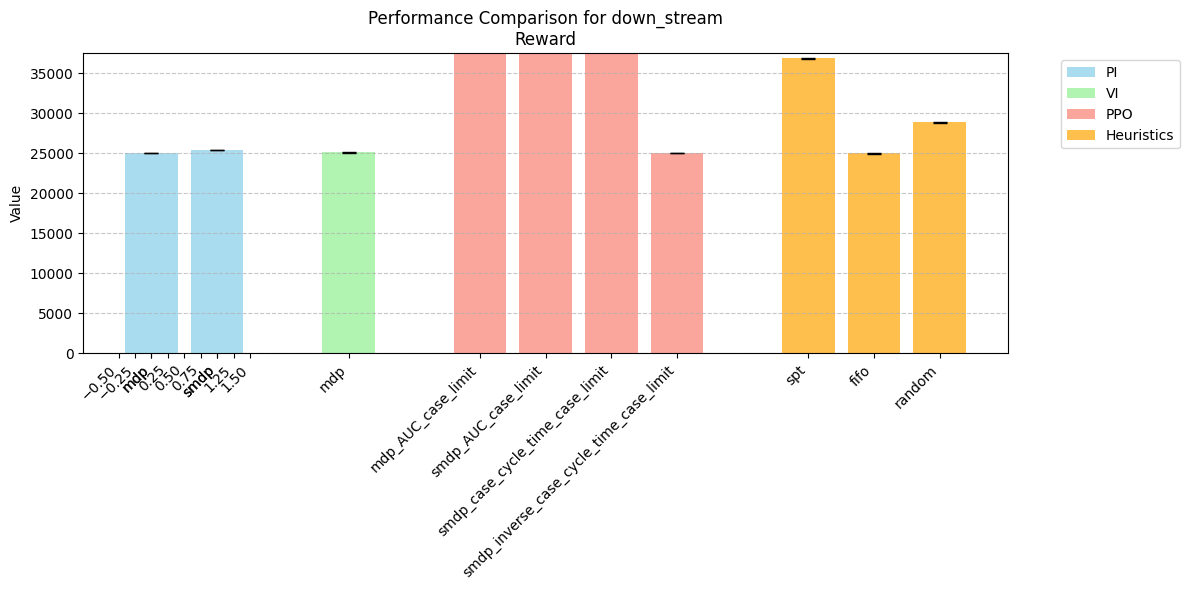

Processing parallel...

Results for parallel:
Best performing model: VI_mdp

PI_mdp: -24513.80(484.69)
PI_smdp: -24636.01(450.63)
VI_mdp: -24257.10(487.05)
PPO_mdp_AUC_case_limit: -584919.30(18401.65)
PPO_smdp_AUC_case_limit: -34107.47(900.84)
PPO_smdp_case_cycle_time_case_limit: -688067.98(20195.30)
PPO_smdp_inverse_case_cycle_time_case_limit: -29504.14(768.88)
Heuristic_spt: -34931.00(921.86)
Heuristic_fifo: -23608.03(451.29)
Heuristic_random: -28237.28(644.98)
PI_mdp vs VI_mdp:
t-statistic: 0.7310
p-value: 0.4651
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 1.1174
p-value: 0.2643
Significant difference: False

Heuristic_fifo vs VI_mdp:
t-statistic: -1.9128
p-value: 0.0563
Significant difference: False

23608.03237386081


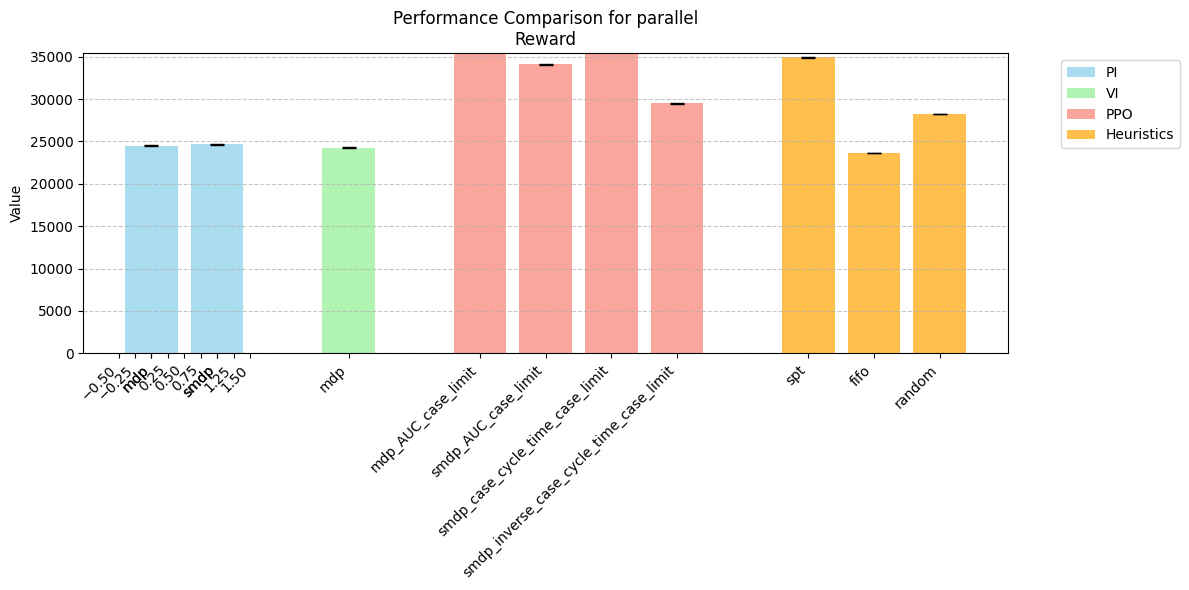

Processing single_activity...

Results for single_activity:
Best performing model: VI_mdp

PI_mdp: -18440.76(229.31)
PI_smdp: -18737.43(270.03)
VI_mdp: -18376.47(260.62)
PPO_mdp_AUC_case_limit: -2487426.62(34898.65)
PPO_smdp_AUC_case_limit: -1259035.20(25399.98)
PPO_smdp_case_cycle_time_case_limit: -2660766.58(35704.90)
PPO_smdp_inverse_case_cycle_time_case_limit: -18870.44(255.18)
Heuristic_spt: -18692.47(222.38)
Heuristic_fifo: -19611.70(276.33)
Heuristic_random: -19333.99(254.20)
Heuristic_threshold: -18352.09(265.44)
PI_mdp vs VI_mdp:
t-statistic: 0.3624
p-value: 0.7172
Significant difference: False

PI_smdp vs VI_mdp:
t-statistic: 1.8821
p-value: 0.0603
Significant difference: False

Heuristic_spt vs VI_mdp:
t-statistic: 1.8048
p-value: 0.0716
Significant difference: False

Heuristic_threshold vs VI_mdp:
t-statistic: -0.1282
p-value: 0.8980
Significant difference: False

18352.08849653867


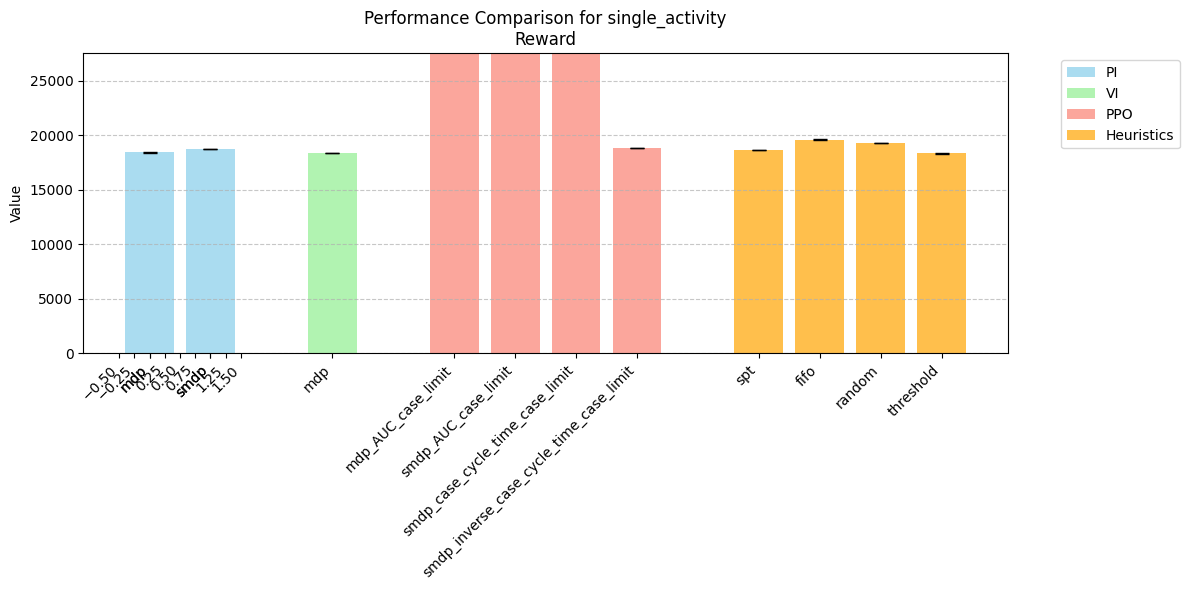

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_mean_ci(df, reward=True):
    if reward:
        df = df['reward']
        mean = abs(df.mean())
        std = df.std()
        ci = 1.96 * std / len(df)
        return mean, ci, np.array(df)
    else:
        df = df['cycle_time']
        mean = abs(df.mean())
        std = df.std()
        ci = 1.96 * std / len(df)
        return mean, ci, np.array(df)

models_to_evaluate = ['ppo', 'heuristics', 'pi', 'vi']
reward=True

data_pi = {}
data_vi = {}
data_ppo = {}
data_heuristics = {}

configs = ["low_utilization", "high_utilization", "slow_server", "n_system", "down_stream", "parallel", "single_activity"]

for config in configs:
    print(f"Processing {config}...")
    # Policy iteration
    if 'pi' in models_to_evaluate:
        for env in ['mdp', 'smdp']:
            df = pd.read_csv(f"./results/pi/pi_{env}_{config}.txt")
            mean, ci, data = get_mean_ci(df, reward=reward)
            data_pi[env] = (mean, ci, data)


    # Value iteration section
    if 'vi' in models_to_evaluate:
        df = pd.read_csv(f"./results/vi/vi_{config}.txt")
        mean, ci, data = get_mean_ci(df, reward=reward)
        data_vi['mdp'] = (mean, ci, data)

    # PPO section
    if 'ppo' in models_to_evaluate:
        for env in ['mdp', 'smdp']:
            reward_functions = ['AUC']
            if env == 'smdp':
                reward_functions.extend(['case_cycle_time', 'inverse_case_cycle_time'])
            for reward_function in reward_functions:
                for stop in ['case_limit']: 
                    df = pd.read_csv(f"./results/ppo/ppo_{config}_{env}_{reward_function}_{stop}.txt")
                    mean, ci, data = get_mean_ci(df, reward=reward)
                    data_ppo[f'{env}_{reward_function}_{stop}'] = (mean, ci, data)

    # Heuristics section
    if 'heuristics' in models_to_evaluate:
        heuristics = ['spt', 'fifo', 'random']
        if config == 'single_activity':
            heuristics.append('threshold')
        for heuristic in heuristics:
            df = pd.read_csv(f"./results/heuristics/{heuristic}_{config}.txt")
            mean, ci, data = get_mean_ci(df, reward=reward)
            data_heuristics[heuristic] = (mean, ci, data)


    """
        Signficance testing
    """
    # Find best performing model
    all_data = []
    model_names = []
    
    # Collect data from each model
    if data_pi:
        for env, (mean, ci, data) in data_pi.items():
            all_data.append(data)
            model_names.append(f"PI_{env}")
            
    if data_vi:
        for env, (mean, ci, data) in data_vi.items():
            all_data.append(data)
            model_names.append(f"VI_{env}")
            
    if data_ppo:
        for key, (mean, ci, data) in data_ppo.items():
            all_data.append(data)
            model_names.append(f"PPO_{key}")
            
    if data_heuristics:
        for heur, (mean, ci, data) in data_heuristics.items():
            all_data.append(data)
            model_names.append(f"Heuristic_{heur}")

    # Find best performing model (lowest mean if minimizing)
    means = [np.mean(data) for data in all_data]
    cis = [1.96 * np.std(data) / np.sqrt(len(data)) for data in all_data]
    best_idx = model_names.index('VI_mdp')
    best_data = all_data[best_idx]
    best_name = model_names[best_idx]
    
    print(f"\nResults for {config}:")
    print(f"Best performing model: {best_name}\n")
    
    for i in range(len(all_data)):
        print(f"{model_names[i]}: {means[i]:.2f}({cis[i]:.2f})")

    # Perform t-tests
    for i, (data, name) in enumerate(zip(all_data, model_names)):
        if i != best_idx:
            t_stat, p_value = stats.ttest_ind(best_data, data)
            if p_value > 0.05:
                print(f"{name} vs {best_name}:")
                print(f"t-statistic: {t_stat:.4f}")
                print(f"p-value: {p_value:.4f}")
                print(f"Significant difference: {p_value < 0.05}\n")



    """
        Plotting the policies
    """

    # Organize data for plotting
    plot_data = []
    labels = []
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange']
    positions = []
    pos = 0
    group_positions = []
    group_labels = []

    # Helper function to add data to plot
    def add_dict_data(data_dict, name):
        global pos
        if data_dict:
            group_start = pos
            means = []
            cis = []
            local_labels = []
            for key, (mean, ci, data) in data_dict.items():
                means.append(mean)
                cis.append(ci)
                local_labels.append(key)
                pos += 1
            
            if means:  # Only if we have data
                plot_data.append((means, cis, local_labels))
                group_positions.append(group_start + (len(means)-1)/2)
                group_labels.append(name)
            pos += 1  # Add space between groups

    # Add data from each dictionary
    add_dict_data(data_pi, "PI")
    add_dict_data(data_vi, "VI")
    add_dict_data(data_ppo, "PPO")
    add_dict_data(data_heuristics, "Heuristics")

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot each group
    bar_width = 0.8
    current_pos = 0
    for i, (means, cis, local_labels) in enumerate(plot_data):
        x = np.arange(current_pos, current_pos + len(means))
        bars = plt.bar(x, means, bar_width, label=group_labels[i], color=colors[i], alpha=0.7)
        
        # Add error bars
        plt.errorbar(x, means, yerr=cis, fmt='none', color='black', capsize=5)
        
        # Add value labels on top of bars
        # for idx, bar in enumerate(bars):
        #     height = bar.get_height()
        #     plt.text(bar.get_x() + bar.get_width()/2., height,
        #             f'{height:.2f}',
        #             ha='center', va='bottom')
        
        # Add local labels
        plt.xticks(np.concatenate([plt.xticks()[0], x]), 
                list(plt.xticks()[1]) + local_labels)
        
        current_pos += len(means) + 1
    min_value = min([min(means) for means, _, _ in plot_data])    
    print(min_value)
    plt.ylim(top=1.5 * min_value)

    # Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Value' if reward else 'Cycle Time')
    plt.title(f'Performance Comparison for {config}\n{"Reward" if reward else "Cycle Time"}')

    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    # Find the minimum value in plot_data
    
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
# Create a LaTeX table from the results
table = r"""
\begin{table}[ht]
\centering
\begin{tabular}{|l|c|c|c|}
\hline
\textbf{Model} & \textbf{Mean} & \textbf{CI} & \textbf{Significant Difference} \\
\hline
"""

# Add data from each model
for i, (data, name) in enumerate(zip(all_data, model_names)):
    mean = np.mean(data)
    ci = 1.96 * np.std(data) / np.sqrt(len(data))
    if i != best_idx:
        t_stat, p_value = stats.ttest_ind(best_data, data)
        significant = "Yes" if p_value < 0.05 else "No"
    else:
        significant = "Best"
    table += f"{name} & {mean:.2f} & {ci:.2f} & {significant} \\\\\n"
    table += "\hline\n"

table += r"""
\end{tabular}
\caption{Performance Comparison for Different Models}
\label{tab:results}
\end{table}
"""

print(table)